# Notebook B: Vocal Tract Resonances, Formants, and Vowel Synthesis

**EE519 — Speech Recognition & Processing for Multimedia**  
**Sudarsana Reddy Kadiri <skadiri@usc.edu>**  

**Lecture Hands-on (Jupyter Notebook)**  
Focus: tube resonances, formant filters, vowel synthesis, vowel space (F1/F2).

---

## Learning goals
1. Connect **time-domain** waveforms to **frequency-domain** spectra (harmonics, resonances).
2. Understand the **source–filter** model: *source* (glottal or noise) → *filter* (vocal tract) → *speech output*.
3. Relate **F0** to pitch and **formants (F1/F2/F3)** to vowel identity.

## How to run
- Run cells top-to-bottom.
- If sliders do not appear, install **ipywidgets** (optional but recommended).

## Deliverables (for students)
- Answer short questions in the **🧠 Checkpoint** cells.
- Complete **✅ Mini-task** sections.

## Dependencies
- Required: `numpy`, `matplotlib`
- Recommended: `scipy` (filters/spectrograms), `ipywidgets` (interactive sliders)


# EE519 Lecture 2 — Notebook B: Vocal Tract Resonances, Formants, and Vowel Synthesis
This notebook focuses on the **filter** part of the source–filter model.

**You will:**
- Model the vocal tract as a **tube resonator** and observe how resonances shift.
- Build a **formant filter** (F1/F2/F3) and synthesize vowels.
- Combine a glottal source with the filter to create simple synthetic speech.

If you completed Notebook 1, you already have an intuitive source model. Here we add the tract filter.


In [12]:

# EE519 Lecture Hands-on Notebooks
# Common setup utilities (used in this notebook)

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

# Optional dependencies
try:
    import scipy
    from scipy import signal
except Exception as e:
    scipy = None
    signal = None
    print("Warning: scipy is not available. Some filtering demos will be limited.", e)

try:
    import ipywidgets as widgets
    from ipywidgets import interact
except Exception as e:
    widgets = None
    interact = None
    print("Warning: ipywidgets is not available. Sliders will not render.", e)

FS = 16000  # sample rate (Hz) — keep small for fast interactive demos

def db(x, eps=1e-12):
    "Convert magnitude to dB safely."
    x = np.maximum(np.asarray(x), eps)
    return 20*np.log10(x)

def plot_time(x, fs=FS, title="Waveform", tlim=None):
    t = np.arange(len(x))/fs
    plt.figure(figsize=(10,3))
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    plt.grid(True, alpha=0.3)
    plt.show()

def spectrum(x, fs=FS, nfft=None, window=True):
    "Return frequency (Hz) and magnitude spectrum (linear) for x."
    x = np.asarray(x)
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(max(1024, len(x)))))
    w = np.hanning(len(x)) if window else np.ones(len(x))
    X = np.fft.rfft(x*w, n=nfft)
    f = np.fft.rfftfreq(nfft, 1/fs)
    mag = np.abs(X)
    return f, mag

def plot_spectrum(x, fs=FS, title="Magnitude Spectrum (dB)", fmax=4000, nfft=None):
    f, mag = spectrum(x, fs=fs, nfft=nfft)
    plt.figure(figsize=(10,3))
    plt.plot(f, db(mag))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title)
    plt.xlim([0, fmax])
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_response(b, a, fs=FS, title="Filter Frequency Response", fmax=5000):
    if signal is None:
        print("scipy.signal unavailable; cannot compute frequency response.")
        return
    w, h = signal.freqz(b, a, worN=2048, fs=fs)
    plt.figure(figsize=(10,3))
    plt.plot(w, db(np.abs(h)))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title)
    plt.xlim([0, fmax])
    plt.grid(True, alpha=0.3)
    plt.show()

def spectrogram(x, fs=FS, title="Spectrogram", nperseg=512, noverlap=384, fmax=5000):
    if signal is None:
        print("scipy.signal unavailable; cannot compute spectrogram.")
        return
    f, t, Sxx = signal.spectrogram(x, fs=fs, window="hann",
                                   nperseg=nperseg, noverlap=noverlap,
                                   scaling="spectrum", mode="magnitude")
    plt.figure(figsize=(10,3.5))
    plt.pcolormesh(t, f, db(Sxx), shading="gouraud")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title(title)
    plt.ylim([0, fmax])
    plt.colorbar(label="Magnitude (dB)")
    plt.show()

def normalize_audio(x, peak=0.95):
    x = np.asarray(x, dtype=float)
    m = np.max(np.abs(x)) + 1e-12
    return (peak/m) * x

# --- Source models ---

def impulse_train(f0=120, dur=1.0, fs=FS):
    "Impulse train at f0 Hz."
    n = int(dur*fs)
    x = np.zeros(n)
    period = int(round(fs/f0))
    x[::period] = 1.0
    return x

def rosenberg_glottal_pulse(f0=120, dur=1.0, fs=FS, open_quotient=0.6, return_quotient=0.2):
    """
    Simple Rosenberg glottal pulse train:
      - opening phase: half cosine up
      - closing phase: half cosine down
      - rest: zero
    open_quotient: fraction of period for open phase (0-1)
    return_quotient: fraction of period for closing phase (0-1), within open phase
    """
    n = int(dur*fs)
    period = int(round(fs/f0))
    x = np.zeros(n)

    To = int(np.clip(open_quotient, 0.05, 0.95) * period)
    Tc = int(np.clip(return_quotient, 0.05, 0.95) * To)
    Ta = To - Tc  # opening part length

    pulse = np.zeros(period)
    if Ta > 1:
        t = np.arange(Ta)
        pulse[:Ta] = 0.5*(1 - np.cos(np.pi * t/(Ta-1)))  # rises 0->1
    if Tc > 1:
        t = np.arange(Tc)
        pulse[Ta:Ta+Tc] = 0.5*(1 + np.cos(np.pi * t/(Tc-1)))  # falls 1->0

    for i in range(0, n, period):
        seg = min(period, n-i)
        x[i:i+seg] = pulse[:seg]
    return x

def add_spectral_tilt(x, fs=FS, tilt_db_per_oct=-12):
    """
    Approximate spectral tilt by a 1st-order lowpass (pedagogical).
    More negative tilt -> lower cutoff (heuristic).
    """
    if signal is None:
        return x
    cutoff = np.clip(3000 + 80*tilt_db_per_oct, 300, 6000)
    b, a = signal.butter(1, cutoff/(fs/2), btype="low")
    return signal.lfilter(b, a, x)

# --- Vocal tract filter models ---

def formant_cascade(formants_hz=(700, 1100, 2500), bandwidths_hz=(80, 90, 120), fs=FS, gain=1.0):
    """
    Create an all-pole cascade filter for given formants (2nd-order resonators).
    Returns (b, a) IIR filter coefficients.
    """
    if signal is None:
        raise RuntimeError("scipy.signal required for IIR design.")
    b = np.array([gain])
    a = np.array([1.0])
    for F, B in zip(formants_hz, bandwidths_hz):
        r = np.exp(-np.pi * B / fs)
        theta = 2*np.pi*F/fs
        a_sec = np.array([1.0, -2*r*np.cos(theta), r**2])
        b_sec = np.array([1.0])  # all-pole section
        b = np.convolve(b, b_sec)
        a = np.convolve(a, a_sec)
    return b, a

def quarter_wave_formants(tube_length_cm=17.0, n_formants=4, c=35000.0):
    """
    Uniform tube, one end closed (glottis), one end open (lips):
    formants at (2k-1)*c/(4L) for k=1..n.
    c in cm/s, L in cm.
    """
    L = tube_length_cm
    ks = np.arange(1, n_formants+1)
    return (2*ks - 1) * c / (4*L)

def mix(a, b, alpha=0.5):
    "alpha=1 -> a, alpha=0 -> b"
    return alpha*np.asarray(a) + (1-alpha)*np.asarray(b)


> **Intuition: longer tube → lower resonances

## B1. Uniform tube resonances (quarter-wave model)
For a simplified uniform tube (closed at glottis, open at lips), resonances occur near:
$F_k = (2k-1)\, \frac{c}{4L}$ 
### Demo
Change tube length and see resonances move.

Tube length: 17.0 cm
Approx resonances (Hz): [ 514.7 1544.1 2573.5 3602.9 4632.4]


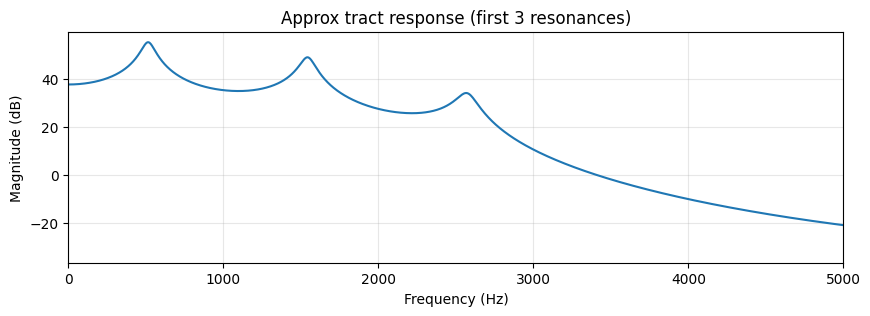

interactive(children=(FloatSlider(value=17.0, description='tube_length_cm', max=20.0, min=12.0, step=0.5), Out…

In [13]:

def demo_tube(tube_length_cm=17.0):
    Fs = quarter_wave_formants(tube_length_cm=tube_length_cm, n_formants=5)
    print(f"Tube length: {tube_length_cm:.1f} cm")
    print("Approx resonances (Hz):", np.round(Fs, 1))

    # Turn resonances into a simple all-pole filter to visualize peaks (first 3)
    bws = [80, 90, 120, 180, 250]
    if signal is None:
        return
    b, a = formant_cascade(formants_hz=Fs[:3], bandwidths_hz=bws[:3], fs=FS, gain=1.0)
    plot_response(b, a, title="Approx tract response (first 3 resonances)", fmax=5000)

if interact is not None:
    interact(demo_tube, tube_length_cm=widgets.FloatSlider(min=12.0, max=20.0, step=0.5, value=17.0))
else:
    demo_tube()


## B2. Formant cascade filter (F1/F2/F3)
A pedagogical vowel model is an **all-pole** filter with peaks at formant frequencies.


Using vowel set: Adult male (approx)


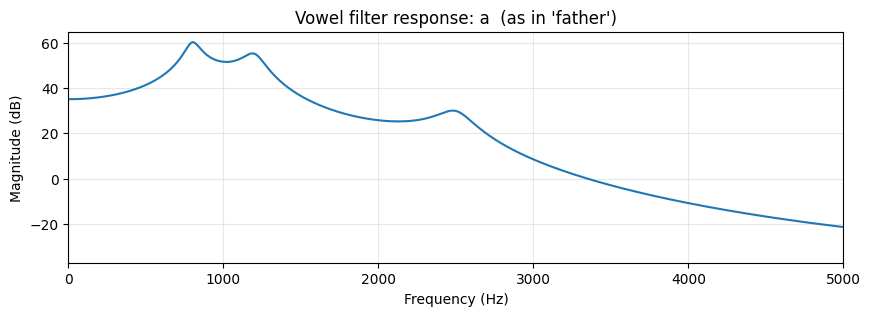

In [14]:

# Approximate vowel tables (Hz). Values vary by speaker/context.
# These are pedagogical defaults; feel free to swap with your own reference.
VOWEL_SETS = {
    "Adult male (approx)": {
        "i  (as in 'beet')": dict(F=(300, 2300, 3000), B=(60, 100, 150)),
        "e  (as in 'bait')": dict(F=(500, 1900, 2600), B=(70, 110, 170)),
        "æ  (as in 'bat')":  dict(F=(700, 1700, 2500), B=(80, 120, 180)),
        "a  (as in 'father')": dict(F=(800, 1200, 2500), B=(90, 130, 200)),
        "o  (as in 'boat')": dict(F=(500,  900, 2400), B=(80, 120, 180)),
        "u  (as in 'boot')": dict(F=(350,  900, 2200), B=(70, 110, 170)),
    },
    "Adult female (approx)": {
        "i  (as in 'beet')": dict(F=(350, 2700, 3300), B=(70, 120, 180)),
        "e  (as in 'bait')": dict(F=(550, 2200, 3000), B=(80, 130, 200)),
        "æ  (as in 'bat')":  dict(F=(850, 2000, 2900), B=(90, 140, 220)),
        "a  (as in 'father')": dict(F=(900, 1400, 2900), B=(100, 150, 240)),
        "o  (as in 'boat')": dict(F=(600, 1000, 2700), B=(90, 140, 220)),
        "u  (as in 'boot')": dict(F=(400, 1000, 2500), B=(80, 130, 200)),
    },
    "Child (approx)": {
        "i  (as in 'beet')": dict(F=(450, 3200, 3800), B=(90, 150, 220)),
        "e  (as in 'bait')": dict(F=(650, 2800, 3500), B=(100, 160, 240)),
        "æ  (as in 'bat')":  dict(F=(1000, 2400, 3300), B=(110, 170, 260)),
        "a  (as in 'father')": dict(F=(1050, 1700, 3300), B=(120, 180, 280)),
        "o  (as in 'boat')": dict(F=(750, 1250, 3100), B=(110, 170, 260)),
        "u  (as in 'boot')": dict(F=(500, 1200, 2900), B=(100, 160, 240)),
    }
}

# Pick a default set
VOWELS = VOWEL_SETS["Adult male (approx)"]

def set_vowel_set(name="Adult male (approx)"):
    global VOWELS
    VOWELS = VOWEL_SETS[name]
    print(f"Using vowel set: {name}")

def plot_vowel_response(name):
    if signal is None:
        return
    F = VOWELS[name]["F"]
    B = VOWELS[name]["B"]
    b, a = formant_cascade(F, B, fs=FS, gain=1.0)
    plot_response(b, a, title=f"Vowel filter response: {name}", fmax=5000)
    return b, a

# Example:
set_vowel_set("Adult male (approx)")
b, a = plot_vowel_response("a  (as in 'father')")


> **Instructor notes:** Before playing audio, ask: *Which part changes vowel identity: source or filter?* Then switch vowels with fixed source.

## B3. Vowel synthesis: source → filter
We generate a glottal source and pass it through the vowel filter.

**Key idea:** output spectrum ≈ source spectrum × tract response.


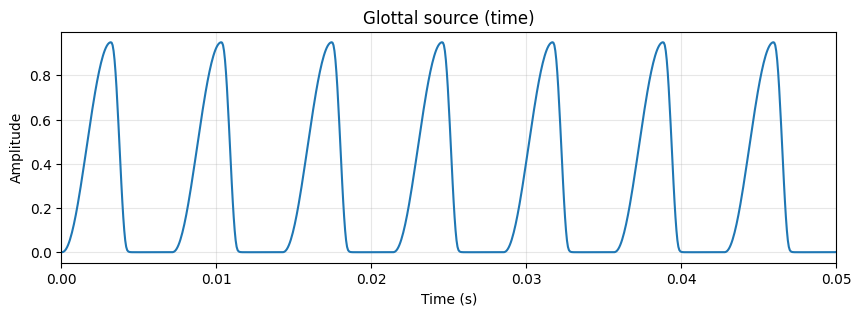

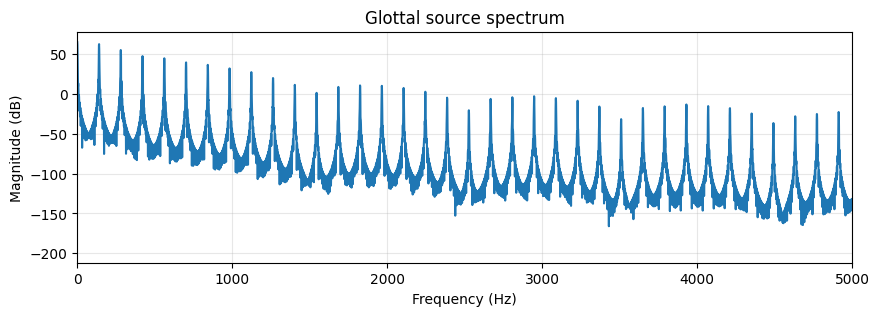

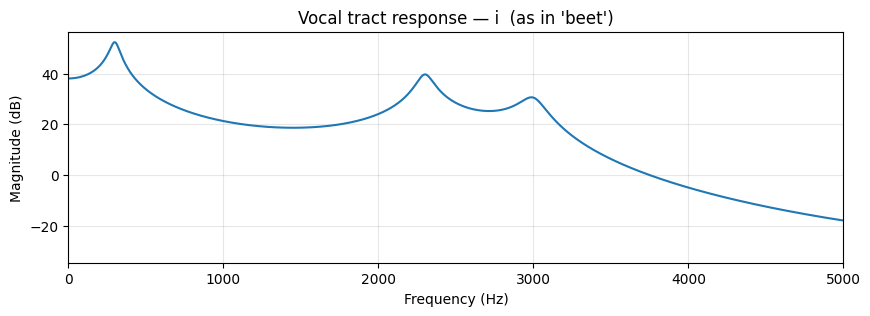

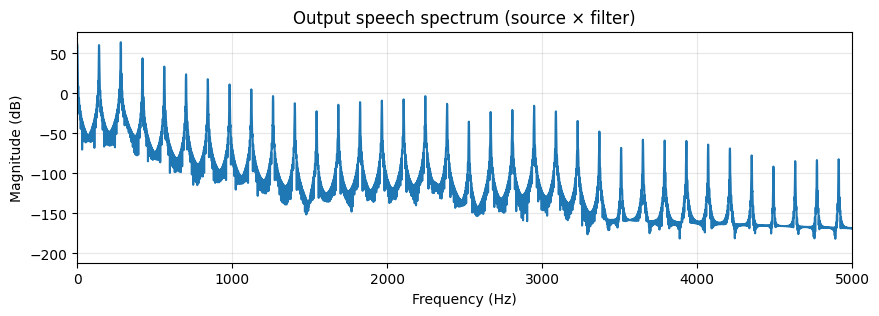

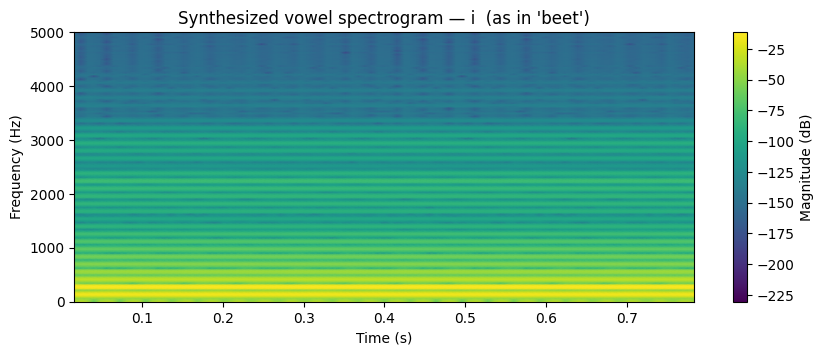

Listen: source (buzz) → vowel (filtered)


(array([0.00000000e+00, 2.79138063e-04, 1.50765124e-03, ...,
        5.59143039e-01, 5.88288252e-01, 6.16988450e-01]),
 array([0.00000000e+00, 2.06813103e-06, 1.92775409e-05, ...,
        1.21734549e-01, 1.77787719e-01, 2.35686221e-01]),
 (array([1.]),
  array([ 1.        , -3.92014251,  7.62514529, -9.27981512,  7.29706888,
         -3.59523111,  0.88538145])))

In [15]:

def synth_vowel(vowel="a  (as in 'father')", f0=120, dur=1.0, oq=0.6, rq=0.25, tilt=-12):
    src = rosenberg_glottal_pulse(f0=f0, dur=dur, open_quotient=oq, return_quotient=rq)
    src = add_spectral_tilt(src, tilt_db_per_oct=tilt)

    if signal is None:
        return
    F = VOWELS[vowel]["F"]
    B = VOWELS[vowel]["B"]
    b, a = formant_cascade(F, B, fs=FS, gain=1.0)
    y = signal.lfilter(b, a, src)

    src_n = normalize_audio(src)
    y_n = normalize_audio(y)

    plot_time(src_n, title="Glottal source (time)", tlim=(0, 0.05))
    plot_spectrum(src_n, title="Glottal source spectrum", fmax=5000)
    plot_response(b, a, title=f"Vocal tract response — {vowel}", fmax=5000)
    plot_spectrum(y_n, title="Output speech spectrum (source × filter)", fmax=5000)
    spectrogram(y_n, title=f"Synthesized vowel spectrogram — {vowel}", fmax=5000)

    print("Listen: source (buzz) → vowel (filtered)")
    display(Audio(src_n, rate=FS))
    display(Audio(y_n, rate=FS))
    return src_n, y_n, (b,a)

synth_vowel(vowel="i  (as in 'beet')", f0=140, dur=0.8)
#synth_vowel(vowel="u  (as in 'boot')", f0=140, dur=0.8)


### Interactive vowel synth (recommended)
Switch vowels while keeping the same source to demonstrate **independence of source and filter**.

## 🧠 Checkpoint
- **Q1:** Keep the same vowel and increase F0. What changes in the spectrum?
- **Q2:** Keep the same F0 and switch vowels. Which peaks move and why?
- **Q3:** In one sentence: what does “independence of source and filter” mean?

**Your answers:**

- Q1:
- Q2:
- Q3:


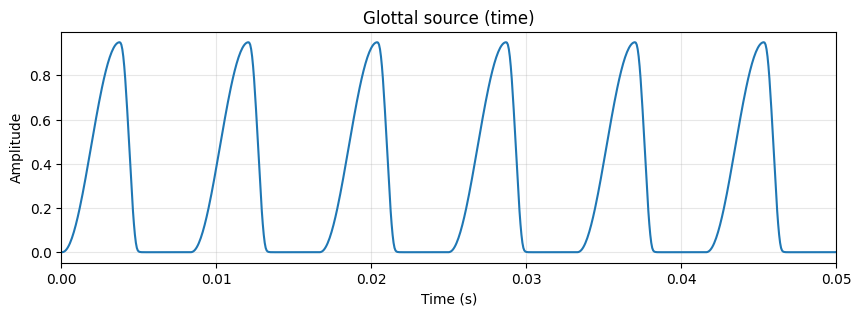

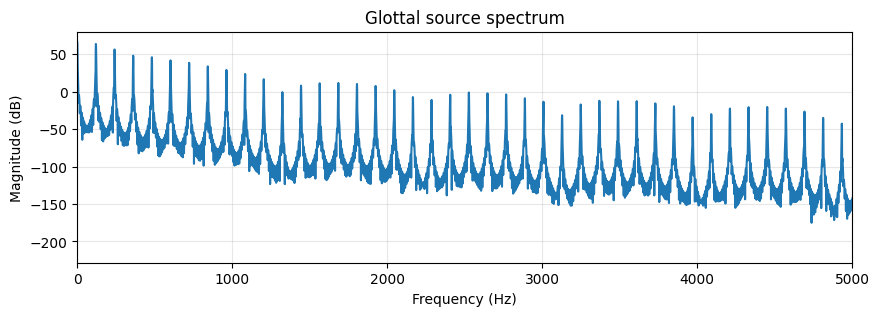

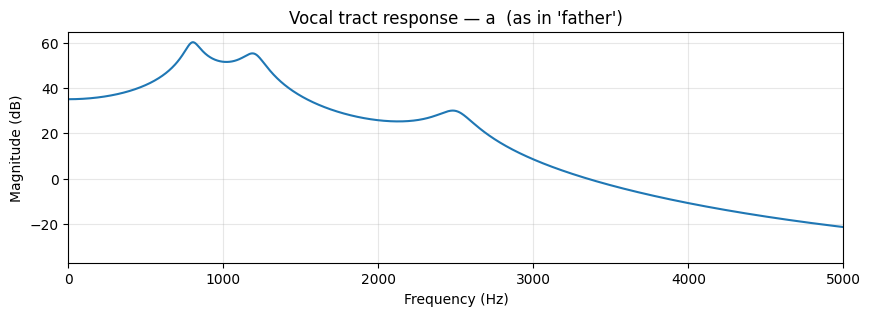

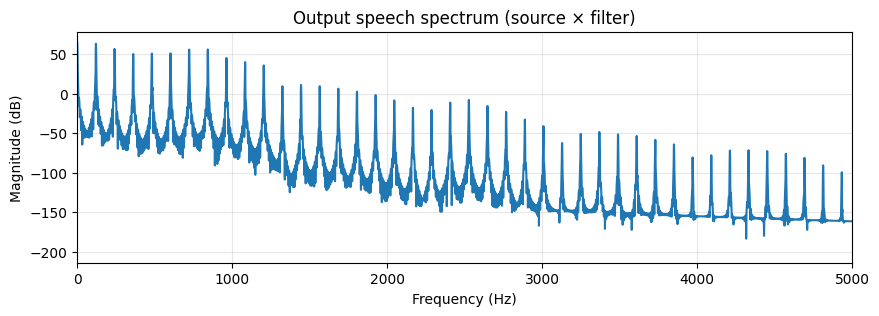

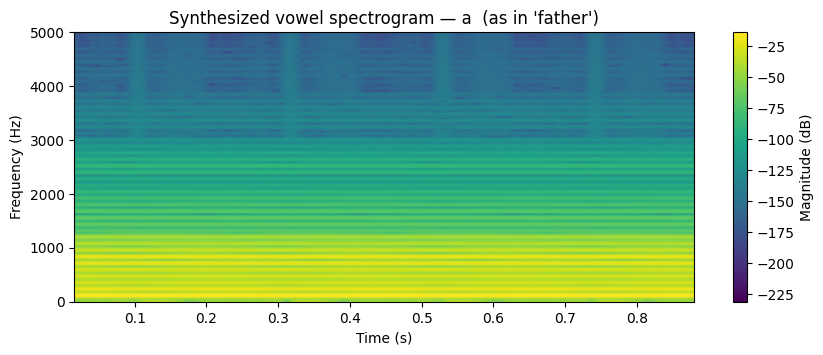

Listen: source (buzz) → vowel (filtered)


interactive(children=(Dropdown(description='vowel', index=3, options=("i  (as in 'beet')", "e  (as in 'bait')"…

In [16]:

def demo_vowel(vowel="a  (as in 'father')", f0=120, oq=0.6, rq=0.25, dur=0.9, tilt=-12):
    synth_vowel(vowel=vowel, f0=f0, oq=oq, rq=rq, dur=dur, tilt=tilt)

if interact is not None:
    interact(demo_vowel,
             vowel=widgets.Dropdown(options=list(VOWELS.keys()), value="a  (as in 'father')"),
             f0=widgets.IntSlider(min=60, max=250, step=5, value=120),
             oq=widgets.FloatSlider(min=0.2, max=0.9, step=0.05, value=0.6),
             rq=widgets.FloatSlider(min=0.1, max=0.9, step=0.05, value=0.25),
             dur=widgets.FloatSlider(min=0.4, max=1.2, step=0.1, value=0.9),
             tilt=widgets.IntSlider(min=-24, max=-3, step=1, value=-12)
            )
else:
    demo_vowel()


> **Instructor notes:** Emphasize trends, not exact numbers. Use it to connect the vowel chart to F1/F2 movement.

## B4. Vowel space intuition: F1/F2 trends
Rule of thumb:
- **F1** increases as vowel height goes **low**
- **F2** decreases as vowel becomes **back**

Below is a pedagogical mapping (height, backness) → (F1,F2,F3).

Estimated formants: F1=480 Hz, F2=2020 Hz, F3=3040 Hz


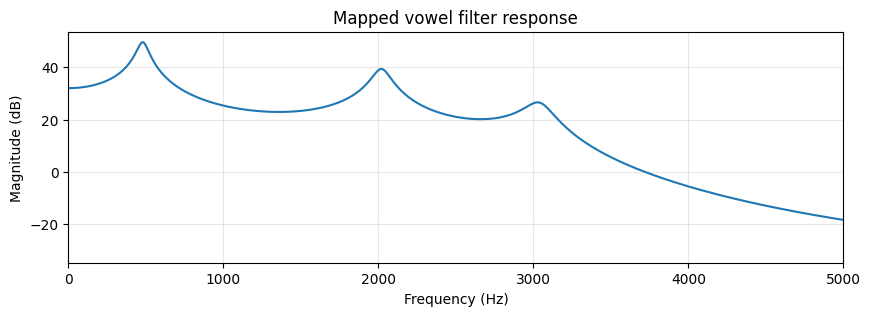

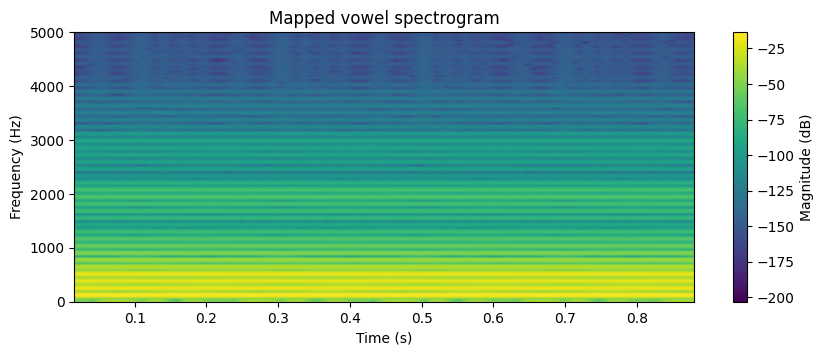

interactive(children=(FloatSlider(value=0.3, description='height', max=1.0, step=0.05), FloatSlider(value=0.2,…

In [17]:

def map_vowel_space(height=0.5, backness=0.5):
    # height: 0 (high) → 1 (low)
    # backness: 0 (front) → 1 (back)
    F1 = 300 + 600*height             # 300..900
    F2 = 2300 - 1400*backness         # 2300..900
    F3 = 3000 - 500*backness + 200*(1-height)
    return (F1, F2, F3)

def demo_space(height=0.3, backness=0.2, f0=130):
    F1, F2, F3 = map_vowel_space(height, backness)
    B1, B2, B3 = 70, 110, 170
    if signal is None:
        return
    b, a = formant_cascade((F1,F2,F3), (B1,B2,B3), fs=FS, gain=1.0)
    src = rosenberg_glottal_pulse(f0=f0, dur=0.9, open_quotient=0.6, return_quotient=0.25)
    y = signal.lfilter(b, a, add_spectral_tilt(src, tilt_db_per_oct=-12))
    y = normalize_audio(y)
    print(f"Estimated formants: F1={F1:.0f} Hz, F2={F2:.0f} Hz, F3={F3:.0f} Hz")
    plot_response(b, a, title="Mapped vowel filter response", fmax=5000)
    spectrogram(y, title="Mapped vowel spectrogram", fmax=5000)
    display(Audio(y, rate=FS))

if interact is not None:
    interact(demo_space,
             height=widgets.FloatSlider(min=0, max=1, step=0.05, value=0.3, description="height"),
             backness=widgets.FloatSlider(min=0, max=1, step=0.05, value=0.2, description="backness"),
             f0=widgets.IntSlider(min=60, max=250, step=5, value=130)
            )
else:
    demo_space()


## B5 (Optional). Lip rounding / lengthening effect
We simulate rounding by lowering formants via a scaling factor (>1 means longer tract → lower formants).

Round factor=1.00. Formants now: [ 350.  900. 2200.] Hz


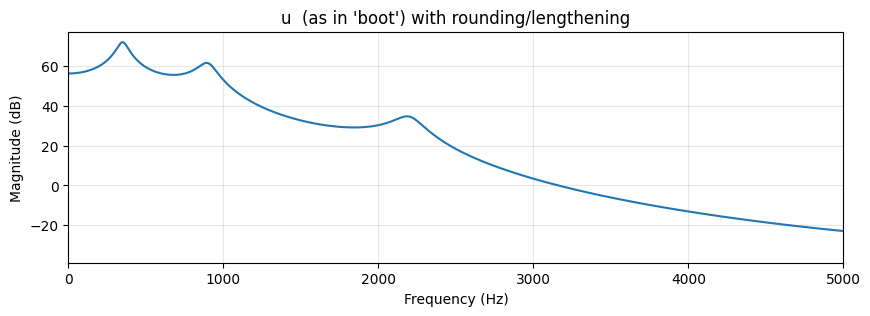

interactive(children=(Dropdown(description='vowel', index=5, options=("i  (as in 'beet')", "e  (as in 'bait')"…

In [18]:

def demo_rounding(vowel="u  (as in 'boot')", round_factor=1.0, f0=120):
    if signal is None:
        return
    F = np.array(VOWELS[vowel]["F"], dtype=float) / round_factor
    B = VOWELS[vowel]["B"]
    b, a = formant_cascade(tuple(F), tuple(B), fs=FS, gain=1.0)

    src = rosenberg_glottal_pulse(f0=f0, dur=0.9, open_quotient=0.6, return_quotient=0.25)
    y = signal.lfilter(b, a, add_spectral_tilt(src, tilt_db_per_oct=-12))
    y = normalize_audio(y)
    print(f"Round factor={round_factor:.2f}. Formants now: {np.round(F,1)} Hz")
    plot_response(b, a, title=f"{vowel} with rounding/lengthening", fmax=5000)
    display(Audio(y, rate=FS))

if interact is not None:
    interact(demo_rounding,
             vowel=widgets.Dropdown(options=list(VOWELS.keys()), value="u  (as in 'boot')"),
             round_factor=widgets.FloatSlider(min=0.9, max=1.4, step=0.02, value=1.0, description="lengthen"),
             f0=widgets.IntSlider(min=60, max=250, step=5, value=120)
            )
else:
    demo_rounding()


## B6 Exercises (recommended)
1. Fix vowel (/a/) and vary **F0** from 80 → 200 Hz. What changes? What stays?
2. Fix F0 and switch vowels /i/ → /a/ → /u/. Which peaks move and why?
3. Choose a point in the (height, backness) slider and report (F1,F2,F3). Describe it as high/low, front/back.

### Challenge (optional)
Add a nasal-like **anti-resonance** using a notch filter and compare audio/spectra.


## ✅ Mini-task 
1. Choose **one vowel** (e.g., /a/) and synthesize it with **two different F0s** (e.g., 90 Hz and 180 Hz).
2. Plot/inspect the two **output spectra**.
3. In 3–4 sentences, explain what changed and what stayed the same.

**Your response:**



## What did you learn?
- 